# Versao final - projeto de Redes Sociais

In [4]:
#Import das bibliotecas e criacao do Graph graph dirigido
import pandas as pd
import netpixi #import das bibliotecas necessáriavalue_countss
from netpixi.integration.gt import *
from regression.integration.gt import *
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib

from random import random, seed

graph = Graph(directed=True) #dirigidonão

In [5]:
# Datesets contendo as citacoes e as informacoes das patentes
citacoes = pd.read_csv("cite75_99.txt",sep=",")
patent_data = pd.read_csv("apat63_99.txt",sep=",")

In [6]:
# Como iremos trabalhar com somente patentes da categoria de computacao
# Iremos remover todos que pertencem a outras categorias
computacao = patent_data[patent_data["CAT"]==2] #CAT 2 esta na documentacao como sendo de computacao
computacao = computacao[computacao["POSTATE"]=='TX']
patentes_computacao = computacao["PATENT"] #pd.series com o numero de todas as patentes de computacao

In [7]:
# Somente uma fracao dessas patentes sera utilizada para montar a rede
# e fazer a regressao logistica
am_pat_comp = patentes_computacao
am_pat_comp

402        3071203
2090       3072892
3260       3074063
3833       3074636
4369       3075172
            ...   
2923879    6009512
2923880    6009513
2923883    6009516
2923891    6009524
2923900    6009533
Name: PATENT, Length: 14266, dtype: int64

In [9]:
# Nesta celula, estamos retirando as patentes gerais que nao pertencem a computacao
cit_comp = citacoes[citacoes["CITING"].isin(am_pat_comp)]
cit_comp = cit_comp[cit_comp["CITED"].isin(am_pat_comp)]

## Preparando o grafo

In [10]:
# Patentes disruptivas eh a variavel independente e patentes importantes eh a variavel dependente
# patentes disruptivas sao medidas pela quantidade de subcategorias de comp que citam ela (qualitativa)
# patentes importantes sao medidas pelo pageRank (quantitativa)
# independente qualitativa e dependente quantitativa
vertex = []
edge = []

# Funcao responsavel por contruir o grafo a partir das informacoes do dataframe cit_comp
def citting(id1,id2):
    id1 = int(id1)
    id2 = int(id2)
    if not graph.has_vertex(id1):
        vertex.append(id1)
        graph.add_vertex(id1)

    if not graph.has_vertex(id2):
        graph.add_vertex(id2)
        vertex.append(id2)
    if not graph.has_edge(id1,id2):
        edge.append([id1,id2])
        edge.append([id1,id2])#ver jeito melhor
        graph.add_edge(id1,id2)
    return id1,id2

a = cit_comp[['CITING', 'CITED']].apply(lambda x: citting(x['CITING'], x['CITED']), axis=1)

In [11]:
# Pegando as metricas locais de degree,pageRank e 
n = graph.num_vertices()
m = graph.num_edges()
if graph.is_directed():
    max_edges = n * (n - 1)
else:
    max_edges = n * (n - 1) // 2
d = m / max_edges

dc = gt_total_degree(graph)
dc_in = gt_in_degree(graph)
dc_out = gt_out_degree(graph)

graph.add_vp('degree',dc)
graph.add_vp('in_degree',dc_in)
graph.add_vp('out_degree',dc_out)

print("Número de vértices = ", n)
print("Número de arestas = ", m)
print("Número máximo de arestas = ", max_edges)
print("Densidade = ",d)

Número de vértices =  9475
Número de arestas =  16632
Número máximo de arestas =  89766150
Densidade =  0.00018528142289716111


In [12]:
#adicionando coluna de SUBCAT de cada vertice
graph.add_vp('SUBCAT')
for i in graph.all_vertices():

    a = computacao[computacao['PATENT'] == i.get_id()]['SUBCAT']
    teste = a.iloc[0]

    i['SUBCAT'] = str(teste)

In [13]:
# Adicionando cor correspondente a SUBCAT
graph.add_vp('color')
for v in graph.all_vertices(): 
    if v['SUBCAT'] == "21":
        v['color'] = 0xffd700
    elif v['SUBCAT'] == "22":
        v['color'] = 0x00ff00
    elif v['SUBCAT'] == "23":
        v['color'] = 0xE69138
    elif v['SUBCAT'] == "24":
        v['color'] = 0x6AA84F
    else:
        print("outro")

In [14]:
# Adicionando a metrica local pageRank para cada vertice
from graph_tool import centrality
pr = centrality.pagerank(graph)
graph.add_vp('pagerank', pr)
gt_data(graph)

,degree,in_degree,out_degree,SUBCAT,color,pagerank
id,,,,,,
3859598,0.000053,0.000000,0.000106,21,16766720,0.000053
3555502,0.000106,0.000211,0.000000,21,16766720,0.000144
3860902,0.000106,0.000000,0.000211,21,16766720,0.000053
3309656,0.000739,0.001478,0.000000,21,16766720,0.000387
3764969,0.000317,0.000633,0.000000,21,16766720,0.000131
...,...,...,...,...,...,...
6009511,0.000264,0.000000,0.000528,22,65280,0.000053
6009513,0.000317,0.000000,0.000633,22,65280,0.000053
6009516,0.000106,0.000000,0.000211,22,65280,0.000053


In [15]:
data = gt_data(graph)
info_vertices = data.copy()
info_vertices.reset_index(inplace=True)

### Encontrando quantas subcategorias uma patente da subcategoria x e citada 

Para isso, merge entre info_vertices e cit_comp. Depois groupby cited 

In [16]:
# Merge para pegar subcat de patente CITED e CITTING
cit_comp_info = cit_comp.merge(info_vertices,left_on='CITED',right_on='id',how='left')
cit_comp_info = cit_comp_info.loc[:,['CITING','CITED','SUBCAT','pagerank']]
cit_comp_info = cit_comp_info.rename(columns={'SUBCAT':'SUBCAT_CITED','pagerank':'pagerank_CITED'})

In [17]:
cit_final = cit_comp_info.merge(info_vertices,left_on='CITING',right_on='id',how='left')
cit_final = cit_final.loc[:,['CITING','CITED','SUBCAT_CITED','pagerank_CITED','SUBCAT','pagerank']]
cit_final = cit_final.rename(columns={'SUBCAT':'SUBCAT_CITING','pagerank':'pagerank_CITING'})

In [18]:
cit_final = cit_final.loc[:,['CITED','SUBCAT_CITED','pagerank_CITED','SUBCAT_CITING']]

In [19]:
cit_final

,CITED,SUBCAT_CITED,pagerank_CITED,SUBCAT_CITING
0,3555502,21,0.000144,21
1,3309656,21,0.000387,21
2,3764969,21,0.000131,21
3,3671931,21,0.000251,22
4,3671931,21,0.000251,22
...,...,...,...,...
16631,5920710,22,0.000061,22
16632,5564028,22,0.000140,22
16633,5742791,24,0.000106,22
16634,5388267,22,0.000261,22


In [20]:
cit_final_entre_pat_diferentes = cit_final[cit_final['SUBCAT_CITED'] != cit_final['SUBCAT_CITING']]
cit_final_entre_pat_iguais = cit_final[cit_final['SUBCAT_CITED'] == cit_final['SUBCAT_CITING']]

In [21]:
a = cit_final_entre_pat_diferentes.groupby(by=['CITED']).nunique()
b = cit_final_entre_pat_iguais.groupby(by=['CITED']).nunique()

In [22]:
a = a.reset_index() #Patente e por quantas subcategorias diferentes ela 'e citada'
b = b.reset_index() #Patente so esta aqui caso tenha sido citada por uma patente de mesma categoria pelo menos uma vez

Caso patente esteja somente em b,quant_subcat=0.

Caso patente esteja em a e b,quant_subcat=valor em a

Caso patente esteja somente em a,quant_subcat=valor em a

In [23]:
a = a.loc[:,['CITED','SUBCAT_CITING']]
b = b.loc[:,['CITED','SUBCAT_CITING']]
a = a.rename(columns={'SUBCAT_CITING':'quant_subcat_diferentes'})
b = b.rename(columns={'SUBCAT_CITING':'quant_subcat_igual'})

In [24]:
correct = a.merge(b,how='outer') #Todas as patentes
# correct['coluna1'].fillna(0, inplace=True)
#Se diferentes e igual for null => quant_total = 0
#Se diferentes for Nan e igual for 1 => quant_total = 0
#Se diferentes for 1 e igual for Nan => quant_total = 1
#Se diferentes for 1 e igual for 1 => quant_total = 1
#...
correct['quant_subcat_diferentes'].fillna(0,inplace=True)
correct['quant_subcat_igual'].fillna(1,inplace=True)
correct['quant_subcat_total'] = correct['quant_subcat_diferentes'] + correct['quant_subcat_igual'] - 1

In [25]:
correct['quant_subcat_total'].describe()

count    5529.000000
mean        0.295894
std         0.492328
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: quant_subcat_total, dtype: float64

In [26]:
# Dataframe correct possui todas as patentes de computacao que foram citadas
# Fazer agora um merge entre correct e info_vertices para pegar o pageRank

final = correct.merge(info_vertices,left_on="CITED",right_on="id")

In [27]:
# Fazendo o staircase encoding para fazer a regressao logistica
values = list(final['quant_subcat_total'].unique())
values.sort()

def staircase_encoding(vals,df):
    length = len(vals) - 1

    dummies = [[] for i in range(length)]

    for value in df['quant_subcat_total']:
        index = vals.index(value)

        for i in range(index):
            dummies[i].append(1)

        for i in range(index, length):
            dummies[i].append(0)

    for value, dummy in zip(values[1:], dummies):
        df[f'quant_subcat_total{value}'] = dummy
    
    return df

data_reg = staircase_encoding(values,final)

In [28]:
data_reg

,CITED,quant_subcat_diferentes,quant_subcat_igual,quant_subcat_total,id,degree,in_degree,out_degree,SUBCAT,color,pagerank,quant_subcat_total1.0,quant_subcat_total2.0,quant_subcat_total3.0
0,3108249,1.0,1.0,1.0,3108249,0.000106,0.000211,0.000000,21,16766720,0.000145,1,0,0
1,3237153,1.0,1.0,1.0,3237153,0.000106,0.000211,0.000000,21,16766720,0.000093,1,0,0
2,3241100,1.0,1.0,1.0,3241100,0.000053,0.000106,0.000000,21,16766720,0.000062,1,0,0
3,3255445,1.0,1.0,1.0,3255445,0.000053,0.000106,0.000000,23,15110456,0.000076,1,0,0
4,3275980,1.0,1.0,1.0,3275980,0.000369,0.000739,0.000000,21,16766720,0.000192,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5524,5905781,0.0,1.0,0.0,5905781,0.000158,0.000211,0.000106,21,16766720,0.000064,0,0,0
5525,5913037,0.0,1.0,0.0,5913037,0.000211,0.000106,0.000317,22,65280,0.000076,0,0,0
5526,5920710,0.0,1.0,0.0,5920710,0.000211,0.000106,0.000317,22,65280,0.000061,0,0,0
5527,5924041,0.0,1.0,0.0,5924041,0.000106,0.000106,0.000106,21,16766720,0.000076,0,0,0


In [29]:
dataa = data_reg.loc[:,['CITED','quant_subcat_total','SUBCAT','pagerank','quant_subcat_total1.0','quant_subcat_total2.0','quant_subcat_total3.0']]

In [30]:
dataa = dataa.rename(columns={'quant_subcat_total1.0':'quant_subcat_total1','quant_subcat_total2.0':'quant_subcat_total2','quant_subcat_total3.0':'quant_subcat_total3'})

## Regressao Logistica

In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import regression as reg

from scipy import stats
from matplotlib import pyplot as plt

In [41]:
result = reg.linear(data=dataa, formula='np.log(pagerank) ~ quant_subcat_total1 + quant_subcat_total2 + quant_subcat_total3')

result.nano_summary()

+0.225 (0.017) ***
+0.622 (0.061) ***
+0.580 (0.322) *


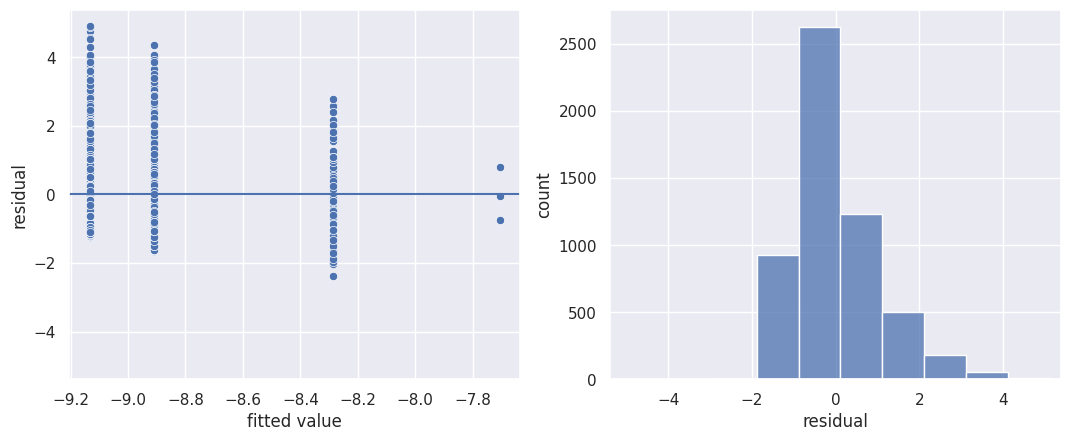

In [42]:
result.plot_residuals()

<AxesSubplot: xlabel='quant_subcat_total', ylabel='pagerank'>

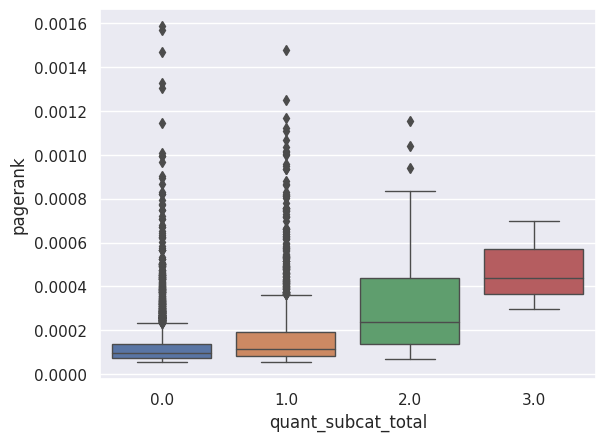

In [43]:
sns.boxplot(x=dataa['quant_subcat_total'], y=dataa['pagerank'], linewidth=1)
# sns.swarmplot(x=dataa['quant_subcat_total1'], y=dataa['pagerank'], linewidth=1)